# Project_Notes_001

## Apartment Prices in Mexico City
In this project, five comma seperated files with a combined data of 23140 rows and 16 columns of apartment data in Mexico City will be used to predict apartment prices. In the end, a diagram will be created so that the prices can be visually generated with sliders on an interact function in Jupyter Widgets.

In [1]:
# Import required libraries.
import warnings

from glob import glob
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# Use glob to create a list of filenames for all the Mexico City real estate CSV files.
files = glob("./data/Project_Notes_001_data_[0-5].csv")
files

['./data\\Project_Notes_001_data_1.csv',
 './data\\Project_Notes_001_data_2.csv',
 './data\\Project_Notes_001_data_3.csv',
 './data\\Project_Notes_001_data_4.csv',
 './data\\Project_Notes_001_data_5.csv']

In [3]:
# Define function that takes a file path as an argument and returns a DataFrame.
def read(filepath):
    df = pd.read_csv(filepath)
    return df

In [4]:
# Use function to create a list named frames.
frames = [read(path) for path in files]

In [5]:
# Concatenate the items in frames into a single DataFrame df.
df = pd.concat(frames)
print("Shape of df:", df.shape)
df.head()

Shape of df: (23140, 16)


operation property_type                   place_with_parent_names  \
0      sell     apartment  |Miguel Hidalgo|Distrito Federal|México|   
1      sell         house      |Iztapalapa|Distrito Federal|México|   
2      sell     apartment         |Tlalpan|Distrito Federal|México|   
3      sell     apartment  |Miguel Hidalgo|Distrito Federal|México|   
4      sell     apartment       |Benito Juárez|Quintana Roo|México|   

                  lat-lon      price currency  price_aprox_local_currency  \
0   23.634501,-102.552788  5500000.0      MXN                  5450245.50   
1     19.31033,-99.068557  1512000.0      MXN                  1498321.97   
2    19.279771,-99.234597   926667.0      MXN                   918284.00   
3   23.634501,-102.552788  6410000.0      MXN                  6352013.39   
4  21.1902642,-86.8198375   875000.0      USD                 16457437.50   

   price_aprox_usd  surface_total_in_m2  surface_covered_in_m2  \
0        289775.66                  NaN                   54.0   
1         79661.96                  NaN                   80.0   
2         48822.82                  NaN                  100.0   
3        337720.36                  NaN                  135.0   
4        875000.00                  0.0                  263.0   

   price_usd_per_m2   price_per_m2  floor  rooms  expenses  \
0               NaN  101851.851900    NaN    NaN       NaN   
1               NaN   18900.000000    NaN    NaN       NaN   
2               NaN    9266.670000    NaN    NaN       NaN   
3               NaN   47481.481480    NaN    NaN       NaN   
4               NaN    3326.996198    NaN    NaN       NaN   

                                       properati_url  
0  http://miguel-hidalgo-df.properati.com.mx/o3zb...  
1  http://iztapalapa.properati.com.mx/q7t0_venta_...  
2  http://tlalpan.properati.com.mx/qbi4_venta_dep...  
3  http://miguel-hidalgo-df.properati.com.mx/opeq...  
4  http://cancun.properati.com.mx/hg4t_venta_depa...

In [6]:
# Get the info of the dataframe.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23140 entries, 0 to 4627
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   23140 non-null  object 
 1   property_type               23140 non-null  object 
 2   place_with_parent_names     23140 non-null  object 
 3   lat-lon                     20698 non-null  object 
 4   price                       22745 non-null  float64
 5   currency                    22745 non-null  object 
 6   price_aprox_local_currency  22745 non-null  float64
 7   price_aprox_usd             22745 non-null  float64
 8   surface_total_in_m2         8633 non-null   float64
 9   surface_covered_in_m2       22215 non-null  float64
 10  price_usd_per_m2            6012 non-null   float64
 11  price_per_m2                21320 non-null  float64
 12  floor                       1531 non-null   float64
 13  rooms                       621 non-n

In [7]:
# Subset data: Apartments in "Capital Federal", less than 100,000.
mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
mask_apt = df["property_type"] == "apartment"
mask_price = df["price_aprox_usd"] < 100_000
df = df[mask_ba & mask_apt & mask_price]

In [8]:
# Subset data: Remove outliers for "surface_covered_in_m2".
low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
mask_area = df["surface_covered_in_m2"].between(low, high)
df = df[mask_area]

In [9]:
# Split "lat-lon" column.
df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
df.drop(columns="lat-lon", inplace=True)  

In [10]:
# Get place name.
df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
df.drop(columns="place_with_parent_names", inplace=True)

In [11]:
# Check output of df.
print("df shape:", df.shape)
df.head()

df shape: (5472, 17)


operation property_type      price currency  price_aprox_local_currency  \
11      sell     apartment  1784569.0      MXN                  1768425.20   
20      sell     apartment  1345000.0      MXN                  1333148.73   
21      sell     apartment  1295000.0      MXN                  1283284.95   
22      sell     apartment   460000.0      MXN                   455838.66   
26      sell     apartment  1786800.0      MXN                  1770635.95   

    price_aprox_usd  surface_total_in_m2  surface_covered_in_m2  \
11         94022.66                  NaN                   57.0   
20         70880.12                 56.0                   56.0   
21         68228.99                  NaN                   80.0   
22         24235.78                  NaN                   60.0   
26         94140.20                  NaN                   50.0   

    price_usd_per_m2  price_per_m2  floor  rooms  expenses  \
11               NaN  31308.228070    NaN    NaN       NaN   
20       1265.716429  24017.857140    NaN    NaN       NaN   
21               NaN  16187.500000    NaN    NaN       NaN   
22               NaN   7666.666667    NaN    NaN       NaN   
26               NaN  35736.000000    NaN    NaN       NaN   

                                        properati_url        lat         lon  \
11  http://benito-juarez.properati.com.mx/pdji_ven...  23.634501 -102.552788   
20  http://iztacalco.properati.com.mx/r6gm_venta_d...  19.402413  -99.095391   
21  http://benito-juarez.properati.com.mx/qvop_ven...  19.357820  -99.149406   
22  http://prados-del-rosario.properati.com.mx/qba...  19.504985  -99.208557   
26  http://prado-churubusco.properati.com.mx/pm05_...  19.354219  -99.126244   

          borough  
11  Benito Juárez  
20      Iztacalco  
21  Benito Juárez  
22   Azcapotzalco  
26       Coyoacán

In [12]:
# Check missing values in df.
df.isnull().sum()

operation                        0
property_type                    0
price                            0
currency                         0
price_aprox_local_currency       0
price_aprox_usd                  0
surface_total_in_m2           4931
surface_covered_in_m2            0
price_usd_per_m2              5087
price_per_m2                     0
floor                         5472
rooms                         5450
expenses                      5472
properati_url                    0
lat                            325
lon                            325
borough                          0
dtype: int64

In [13]:
# Extract columns with missing values with more than halve the data.
[col for col in df.columns if df[col].isnull().sum() > df.shape[0]/2]

['surface_total_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses']

In [14]:
# Remove columns from df.
df.drop(columns=['surface_total_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses'], inplace=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5472 entries, 11 to 4618
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   5472 non-null   object 
 1   property_type               5472 non-null   object 
 2   price                       5472 non-null   float64
 3   currency                    5472 non-null   object 
 4   price_aprox_local_currency  5472 non-null   float64
 5   price_aprox_usd             5472 non-null   float64
 6   surface_covered_in_m2       5472 non-null   float64
 7   price_per_m2                5472 non-null   float64
 8   properati_url               5472 non-null   object 
 9   lat                         5147 non-null   float64
 10  lon                         5147 non-null   float64
 11  borough                     5472 non-null   object 
dtypes: float64(7), object(5)
memory usage: 555.8+ KB
None


operation property_type      price currency  price_aprox_local_currency  \
11      sell     apartment  1784569.0      MXN                  1768425.20   
20      sell     apartment  1345000.0      MXN                  1333148.73   
21      sell     apartment  1295000.0      MXN                  1283284.95   
22      sell     apartment   460000.0      MXN                   455838.66   
26      sell     apartment  1786800.0      MXN                  1770635.95   

    price_aprox_usd  surface_covered_in_m2  price_per_m2  \
11         94022.66                   57.0  31308.228070   
20         70880.12                   56.0  24017.857140   
21         68228.99                   80.0  16187.500000   
22         24235.78                   60.0   7666.666667   
26         94140.20                   50.0  35736.000000   

                                        properati_url        lat         lon  \
11  http://benito-juarez.properati.com.mx/pdji_ven...  23.634501 -102.552788   
20  http://iztacalco.properati.com.mx/r6gm_venta_d...  19.402413  -99.095391   
21  http://benito-juarez.properati.com.mx/qvop_ven...  19.357820  -99.149406   
22  http://prados-del-rosario.properati.com.mx/qba...  19.504985  -99.208557   
26  http://prado-churubusco.properati.com.mx/pm05_...  19.354219  -99.126244   

          borough  
11  Benito Juárez  
20      Iztacalco  
21  Benito Juárez  
22   Azcapotzalco  
26       Coyoacán

In [15]:
# Extract object columns fron data.
df_obj = df.select_dtypes(include="object")
df_obj.head()

operation property_type currency  \
11      sell     apartment      MXN   
20      sell     apartment      MXN   
21      sell     apartment      MXN   
22      sell     apartment      MXN   
26      sell     apartment      MXN   

                                        properati_url        borough  
11  http://benito-juarez.properati.com.mx/pdji_ven...  Benito Juárez  
20  http://iztacalco.properati.com.mx/r6gm_venta_d...      Iztacalco  
21  http://benito-juarez.properati.com.mx/qvop_ven...  Benito Juárez  
22  http://prados-del-rosario.properati.com.mx/qba...   Azcapotzalco  
26  http://prado-churubusco.properati.com.mx/pm05_...       Coyoacán

In [16]:
# Check dimensionality of object columns.
df_obj.nunique()

operation           1
property_type       1
currency            1
properati_url    5472
borough            15
dtype: int64

In [17]:
# Extract objects columns with dimensionality not between 2 and 99.
[col for col in df_obj.columns if df_obj[col].nunique() not in range(2,99)]

['operation', 'property_type', 'currency', 'properati_url']

In [18]:
# Remove high dimentionality columns from df.
df.drop(columns=['operation', 'property_type', 'currency', 'properati_url'], inplace=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5472 entries, 11 to 4618
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   price                       5472 non-null   float64
 1   price_aprox_local_currency  5472 non-null   float64
 2   price_aprox_usd             5472 non-null   float64
 3   surface_covered_in_m2       5472 non-null   float64
 4   price_per_m2                5472 non-null   float64
 5   lat                         5147 non-null   float64
 6   lon                         5147 non-null   float64
 7   borough                     5472 non-null   object 
dtypes: float64(7), object(1)
memory usage: 384.8+ KB
None


price  price_aprox_local_currency  price_aprox_usd  \
11  1784569.0                  1768425.20         94022.66   
20  1345000.0                  1333148.73         70880.12   
21  1295000.0                  1283284.95         68228.99   
22   460000.0                   455838.66         24235.78   
26  1786800.0                  1770635.95         94140.20   

    surface_covered_in_m2  price_per_m2        lat         lon        borough  
11                   57.0  31308.228070  23.634501 -102.552788  Benito Juárez  
20                   56.0  24017.857140  19.402413  -99.095391      Iztacalco  
21                   80.0  16187.500000  19.357820  -99.149406  Benito Juárez  
22                   60.0   7666.666667  19.504985  -99.208557   Azcapotzalco  
26                   50.0  35736.000000  19.354219  -99.126244       Coyoacán

In [19]:
# Check correlation of numerical columns.
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
corr

price  price_aprox_local_currency  \
price                       1.000000                    0.999987   
price_aprox_local_currency  0.999987                    1.000000   
surface_covered_in_m2       0.272829                    0.272827   
price_per_m2                0.892298                    0.892276   
lat                         0.073674                    0.073613   
lon                        -0.107735                   -0.107674   

                            surface_covered_in_m2  price_per_m2       lat  \
price                                    0.272829      0.892298  0.073674   
price_aprox_local_currency               0.272827      0.892276  0.073613   
surface_covered_in_m2                    1.000000     -0.163493 -0.033020   
price_per_m2                            -0.163493      1.000000  0.098808   
lat                                     -0.033020      0.098808  1.000000   
lon                                     -0.003069     -0.115597 -0.852664   

                                 lon  
price                      -0.107735  
price_aprox_local_currency -0.107674  
surface_covered_in_m2      -0.003069  
price_per_m2               -0.115597  
lat                        -0.852664  
lon                         1.000000

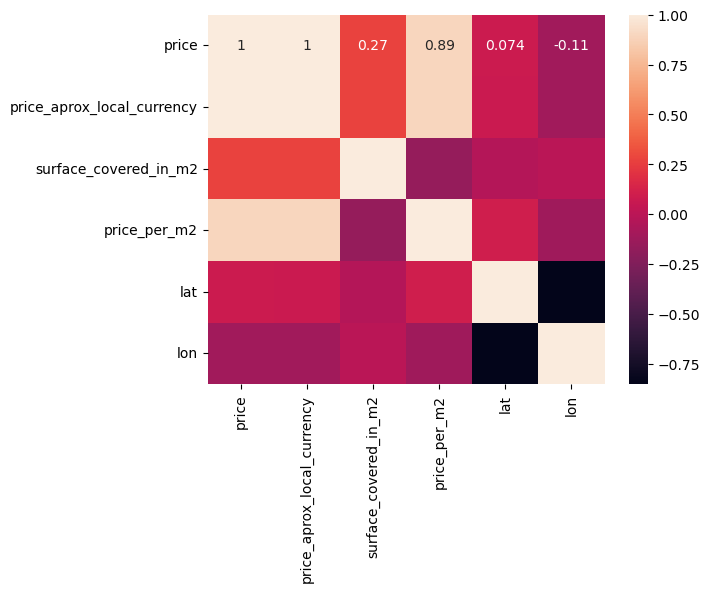

In [20]:
# Draw the correlation heatmap.
sns.heatmap(corr, annot=True);

In [21]:
# Remove price_aprox_local_currency column from df.
df.drop(columns=['price', 'price_aprox_local_currency', 'price_per_m2'], inplace=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5472 entries, 11 to 4618
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5472 non-null   float64
 1   surface_covered_in_m2  5472 non-null   float64
 2   lat                    5147 non-null   float64
 3   lon                    5147 non-null   float64
 4   borough                5472 non-null   object 
dtypes: float64(4), object(1)
memory usage: 256.5+ KB
None


price_aprox_usd  surface_covered_in_m2        lat         lon  \
11         94022.66                   57.0  23.634501 -102.552788   
20         70880.12                   56.0  19.402413  -99.095391   
21         68228.99                   80.0  19.357820  -99.149406   
22         24235.78                   60.0  19.504985  -99.208557   
26         94140.20                   50.0  19.354219  -99.126244   

          borough  
11  Benito Juárez  
20      Iztacalco  
21  Benito Juárez  
22   Azcapotzalco  
26       Coyoacán

In [22]:
# Build function to precess the data.
def process(filepath):
    
    # Use glob to create a list of filenames for all the Mexico City real estate CSV files.
    files = glob("./data/Project_Notes_001_data_[0-5].csv")
    
    # Define function that takes a file path as an argument and returns a DataFrame.
    def read(filepath):
        df = pd.read_csv(filepath)
        return df

    # Use function to create a list named frames.
    frames = [read(path) for path in files]

    # Concatenate the items in frames into a single DataFrame df.
    df = pd.concat(frames)

    # Subset data: Apartments in "Capital Federal", less than 100,000.
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2".
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column.
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name.
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop any columns that are more than half NaN values.
    df.drop(columns=['surface_total_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses'], inplace=True)
    
    # Drop categorical columns with low or high cardinality.
    df.drop(columns=['operation', 'property_type', 'currency', 'properati_url'], inplace=True)
    
    # Drop columns with multicollinearity.
    df.drop(columns=['price', 'price_aprox_local_currency', 'price_per_m2'], inplace=True)
    
    return df

In [23]:
# Check output of the new function.
df = process("./data/Project_Notes_001_data_[0-5].csv")
print("df shape:", df.shape)
df.head()

df shape: (5472, 5)


price_aprox_usd  surface_covered_in_m2        lat         lon  \
11         94022.66                   57.0  23.634501 -102.552788   
20         70880.12                   56.0  19.402413  -99.095391   
21         68228.99                   80.0  19.357820  -99.149406   
22         24235.78                   60.0  19.504985  -99.208557   
26         94140.20                   50.0  19.354219  -99.126244   

          borough  
11  Benito Juárez  
20      Iztacalco  
21  Benito Juárez  
22   Azcapotzalco  
26       Coyoacán

Text(0, 0.5, 'Count')

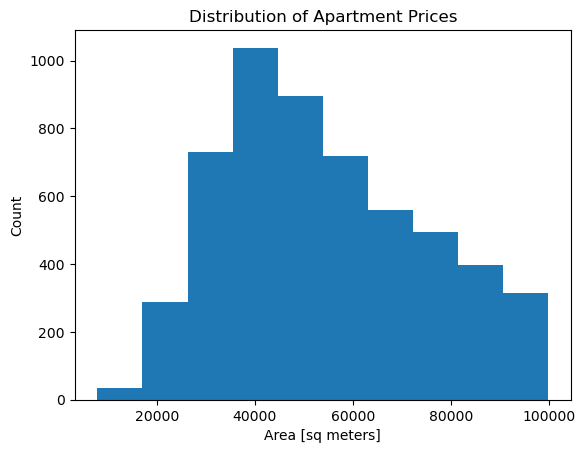

In [24]:
# Plot distribution of price.
plt.hist(df["price_aprox_usd"])
plt.title("Distribution of Apartment Prices")
plt.xlabel("Area [sq meters]")
plt.ylabel("Count")

Text(0.5, 1.0, 'Mexico City: Price vs. Area')

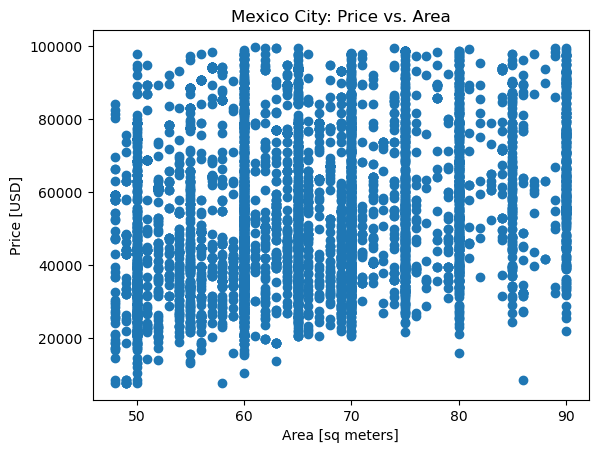

In [25]:
# Plot price vs area.
plt.scatter(df["surface_covered_in_m2"], df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Mexico City: Price vs. Area")

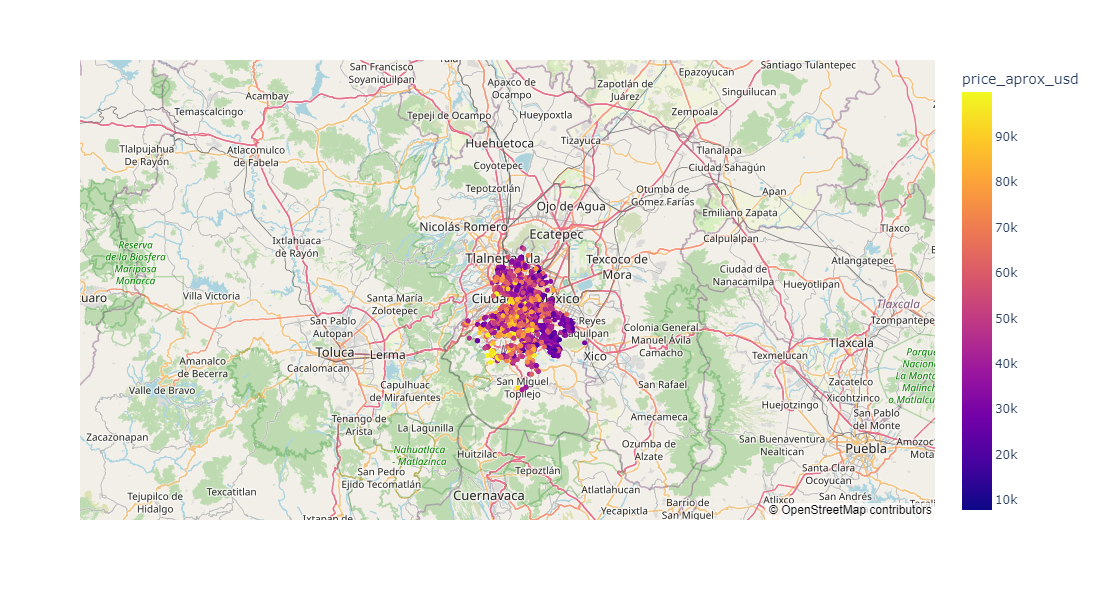

In [26]:
# Plot Mapbox location and price.
fig = px.scatter_mapbox(
    df,  # The DataFrame.
    lat="lat",
    lon="lon",
    width=600,  # Width of map.
    height=600,  # Height of map.
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house.
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

In [27]:
# Split data into feature matrix `X_train` and target vector `y_train`.
target = "price_aprox_usd"
features = df.drop(columns=target).columns.values
y_train = df[target]
X_train = df[features]

In [28]:
# Calculate the baseline mean absolute error for your model
y_mean = round(y_train.mean(), 2)
y_pred_baseline = [y_mean for items in range(len(y_train))]
baseline_mae = round((sum((y_train - y_pred_baseline)**2))**0.5, 2)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54202.2
Baseline MAE: 1517646.82


In [29]:
# Build Model
one_hot = OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
rig_mod = Ridge()
model = make_pipeline(one_hot, imputer, rig_mod)

# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [30]:
# Read the CSV file mexico-city-test-features.csv into the DataFrame X_test
X_test = pd.read_csv('data/Project_Notes_001_data_features.csv')
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   int64  
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.7+ KB
None


surface_covered_in_m2        lat        lon        borough
0                     60  19.493185 -99.205755   Azcapotzalco
1                     55  19.307247 -99.166700       Coyoacán
2                     50  19.363469 -99.010141     Iztapalapa
3                     60  19.474655 -99.189277   Azcapotzalco
4                     74  19.394628 -99.143842  Benito Juárez

In [31]:
# Use your model to generate a Series of predictions for X_test
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53606.013439
1    53323.532445
2    34336.343842
3    53556.125543
4    68707.558562
dtype: float64

In [32]:
# Create a Series named feat_imp
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(data=coefficients, index=features)
feat_imp

surface_covered_in_m2               284.991851
lat                                 490.410611
lon                               -2476.064277
borough_Benito Juárez             13816.975053
borough_Iztacalco                   379.533847
borough_Azcapotzalco               2503.681881
borough_Coyoacán                   3834.048801
borough_Álvaro Obregón             3043.701288
borough_Iztapalapa               -13368.102264
borough_Cuauhtémoc                 -319.440108
borough_Tláhuac                  -14208.659861
borough_Miguel Hidalgo             2004.646937
borough_Venustiano Carranza       -5609.969392
borough_Tlalpan                   10346.978177
borough_Gustavo A. Madero         -6631.577745
borough_Xochimilco                  948.122862
borough_La Magdalena Contreras    -5907.894678
borough_Cuajimalpa de Morelos      9167.955201
dtype: float64

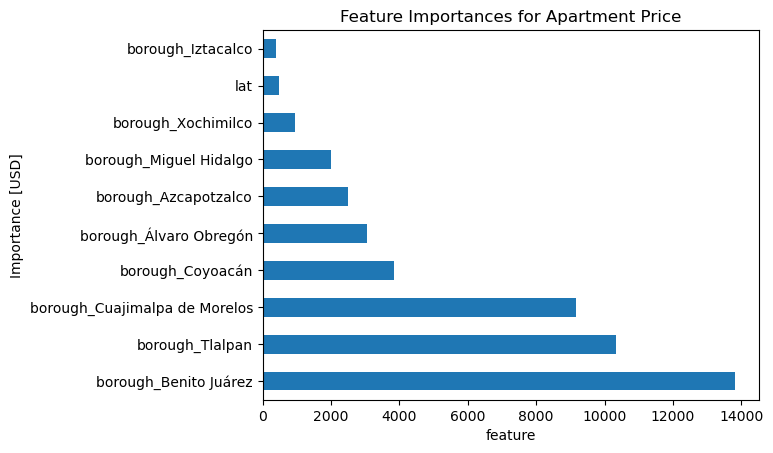

In [33]:
# Create horizontal bar chart
feat_imp.sort_values(axis=0, ascending=False)[0:10].plot(kind="barh", 
                     xlabel="feature", ylabel="Importance [USD]", 
                     title="Feature Importances for Apartment Price");

In [34]:
# Create a function make_prediction that takes four arguments

def predict(area, lat, lon, borough):
    data = {"surface_covered_in_m2": area,
            "lat": lat,
            "lon": lon,
            "borough": borough}
    
    df = pd.DataFrame(data, index=[0])
    
    prediction = model.predict(df).round(2)[0]
    
    return f"Predicted apartment price: ${prediction}"

In [35]:
input = df.loc[0].to_list()
input

[63223.78, 88.0, 19.516777, -99.160149, 'Gustavo A. Madero']

In [36]:
predict(input[0], input[1], input[2], input[3])

'Predicted apartment price: $17791896.77'

In [37]:
# Create an interact function in Jupyter Widgets
interact(
    predict,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    borough=Dropdown(options=sorted(X_train["borough"].unique())),
);

interactive(children=(IntSlider(value=66, description='area', max=90, min=48), FloatSlider(value=19.4532547421…